# OCR 서비스 - 간판 읽기
* 간판을 자동으로 읽어 자동으로 지도와 가게 이름을 연동하는 서비스

#### 모델 평가 지표
* 일반적인 텍스트를 잘 인식한다.
* 작은 텍스트도 잘 인식한다.
* 필기체 등 일반적이지 않은 형태의 텍스트도 잘 인식한다.
* 회전된 텍스트를 잘 인식한다.

## 1. OCR 테스트
### (1) Google OCR API

In [48]:
import os
 
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/signboard'
file_list = os.listdir(img_dir)
file_list.remove('.ipynb_checkpoints')
file_list

['5.jpg',
 '1.jpg',
 '8.jpg',
 '7.jpg',
 '9.jpg',
 '4.jpg',
 '2.jpg',
 '6.jpg',
 '3.jpg']

In [35]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [36]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# !ls -l $GOOGLE_APPLICATION_CREDENTIALS
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    print(f'[{file}]')
    detect_text(os.path.join(img_dir, file))
    print()

[5.jpg]
Texts:

"YOU
FAN
COCO
dlessert cate, estaurant
"

"YOU"

"FAN"

"COCO"

"dlessert"

"cate,"

"estaurant"
bounds: (371,330),(535,332),(535,367),(371,365)

[1.jpg]
Texts:

"UNIX Kitchen
"

"UNIX"

"Kitchen"
bounds: (102,77),(194,70),(196,107),(105,114)

[8.jpg]
Texts:

"DEVICEIC
DEVICE IN
간판을
만드는 집
"

"DEVICEIC"

"DEVICE"

"IN"

"간판"

"을"

"만드는"

"집"
bounds: (42,199),(48,199),(48,206),(42,206)

[7.jpg]
Texts:

"MOMO STUDIO
"

"MOMO"

"STUDIO"
bounds: (302,249),(395,249),(395,267),(302,267)

[9.jpg]
Texts:

"greenougi
010,5468.8103
salad
Salaa
gurt
drink
Dri
ALAU
"

"greenougi"

"010,5468.8103"

"salad"

"Salaa"

"gurt"

"drink"

"Dri"

"ALAU"
bounds: (1166,0),(1298,179),(1241,220),(1110,42)

[4.jpg]
Texts:

"Sclmea
CICIE BE
"

"Sclmea"

"CICIE"

"BE"
bounds: (21,173),(32,173),(32,179),(21,179)

[2.jpg]
Texts:

"STAY
flowercafe
"

"STAY"

"flowercafe"
bounds: (385,116),(436,117),(436,125),(385,124)

[6.jpg]
Texts:

"BRO
Honest Bread
GIA IS
"

"BRO"

"Honest"

"Bread"

"GIA"

"IS"


### (2) Keras - OCR

In [37]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [38]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


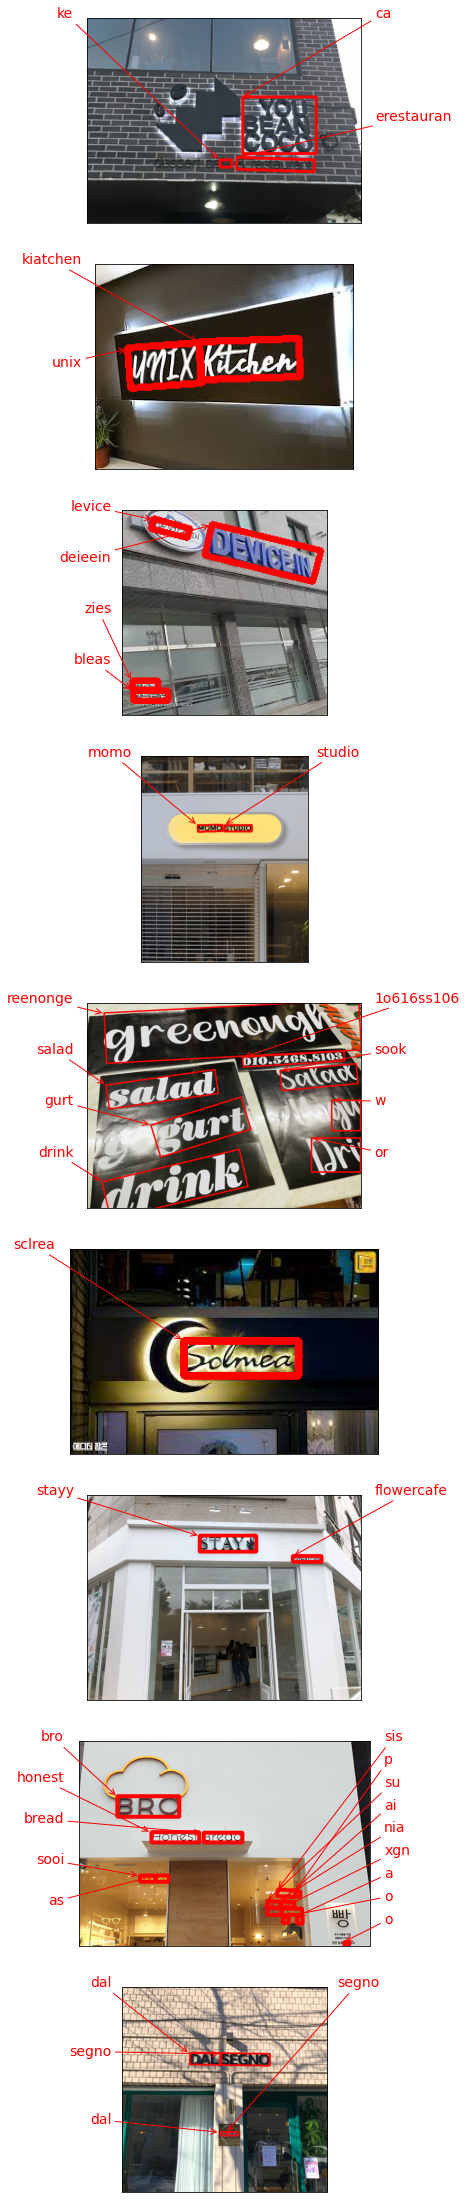

In [39]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### (3) Tesseract

In [40]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [41]:
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_cropped'

for file in file_list:
    print(f'[{file}]')
    try:
        recognize_images(os.path.join(img_dir, file), save_dir)
    except:
        print(f'Cannot recognize characters from {file}')

[5.jpg]
Cannot recognize characters from 5.jpg
[1.jpg]
-—

Done
[8.jpg]
Cannot recognize characters from 8.jpg
[7.jpg]
Cannot recognize characters from 7.jpg
[9.jpg]

Done
[4.jpg]
& 2

Done
[2.jpg]

Done
[6.jpg]
in

“BRO


Done
[3.jpg]

on

Done


## 2. 테스트 결과 분석

In [42]:
def compare_ocr(file):
    print('[keras-ocr]')
    idx = file_list.index(file)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('\n[Google OCR]')
    detect_text(os.path.join(img_dir, file))
    print('\n[Tesseract]')
    recognize_images(os.path.join(img_dir, file), save_dir)

### (1) 필기체로 쓰여진 간판
* Keras OCR과 Google OCR은 필기체임에도 글자를 잘 인식했다.
* Tesseract는 아예 글자를 인식하지 못했다.

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


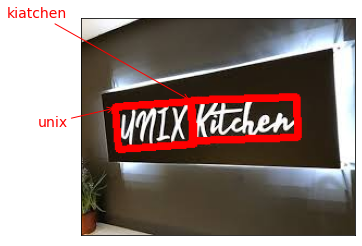


[Google OCR]
Texts:

"UNIX Kitchen
"

"UNIX"

"Kitchen"
bounds: (102,77),(194,70),(196,107),(105,114)

[Tesseract]
-—

Done


In [43]:
compare_ocr('1.jpg')

### (2) 정자로 쓰여진 간판
* 큰 글자와 비교적 작은 글자로 이루어진 간판은 Google OCR이 가장 정확하게 인식했다.
* keras ocr도 잘 인식해내긴 했으나 글자가 아닌 객체를 글자로 인식하는 오류가 발생했다.
* Tesseract는 이번에도 글자를 인식하지 못했다.

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


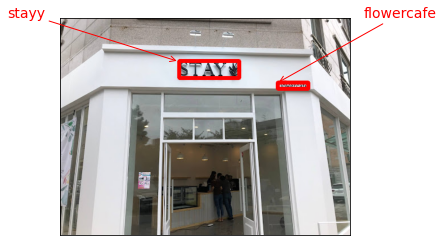


[Google OCR]
Texts:

"STAY
flowercafe
"

"STAY"

"flowercafe"
bounds: (385,116),(436,117),(436,125),(385,124)

[Tesseract]

Done


In [44]:
compare_ocr('2.jpg')

### (3) 작은 글자가 포함된 간판
* 확대를 해야 보일정도로 작은 글자가 포함된 간판의 경우에는 keras ocr은 비교적 큰 글자는 인식할 수 있었으나 더 작은 글자는 인식하지 못했다.
* Google OCR의 경우 매우 작은 글자 'COFFEE&DESSERT' 라는 글자를 어느정도 비슷하게 인식해 내는 결과를 보여줬다.
* 하지만 Tesseract의 경우 이번에도 글자를 인식하지 못했다.

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


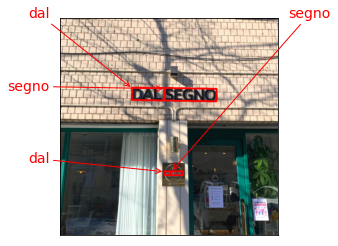


[Google OCR]
Texts:

"DAL SEGNO
DAL SEGNO
corrEE
Nal segno
"

"DAL"

"SEGNO"

"DAL"

"SEGNO"

"corrEE"

"Nal"

"segno"
bounds: (571,599),(601,604),(598,621),(568,617)

[Tesseract]

on

Done


In [45]:
compare_ocr('3.jpg')

### (4) 겹치는 텍스트와 빛번짐이 있는 간판
* Keras OCR의 경우 빛번짐이 발생한 텍스트의 경우 잘 인식해내지 못한다. 또한 숫자를 잘 인식하지 못하는 경향을 보인다.
* Google OCR의 경우는 숫자도 잘 인식하고 전체적인 텍스트를 잘 인식해 냈다. 하지만 Google OCR 역시 빛번짐은 잘 인식하지 못했다.
* Tesseract는 여전히 글자를 인식하지 못했다.

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


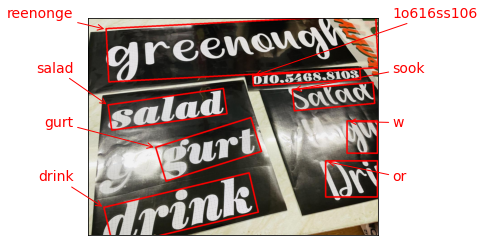


[Google OCR]
Texts:

"greenougi
010,5468.8103
salad
Salaa
gurt
drink
Dri
ALAU
"

"greenougi"

"010,5468.8103"

"salad"

"Salaa"

"gurt"

"drink"

"Dri"

"ALAU"
bounds: (1166,0),(1298,179),(1241,220),(1110,42)

[Tesseract]

Done


In [47]:
compare_ocr('9.jpg')

## 3. 결론
* 다양한 간판 이미지에 대한 OCR 테스트를 진행한 결과는 다음과 같다.
|평가기준|Google OCR|Keras OCR|Tesseract|
|-----|---|---|---|
|일반적인 텍스트를 잘 인식하는가?| O | O | X |
|작은 텍스트를 잘 인식하는가? | O | O | X |
|필기체 등 일반적이지 않은 형태의 텍스트도 잘 인식하는가? | O | X | X |
|회전된 텍스트를 잘 인식하는가? | O | O | X |

* 위 표를 통해 확인할 수 있듯이 서비스에 가장 적절한 모델은 Google OCR이다.
* Tesseract의 경우는 사용이 어려울 것 같다.